## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

In [3]:
import numpy as np
import pandas as pd
from matplotlib import gridspec
import matplotlib.pyplot as plt

from sklearn.utils.extmath import softmax
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.utils import check_array, check_X_y, column_or_1d
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.model_selection import train_test_split

from abc import ABCMeta, abstractmethod
from pysim.aspline import ASplineClassifier, ASplineRegressor

from rpy2 import robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

fps = importr("fps")
numpy2ri.activate()


def soft_thres(x, t):
    return np.sign(x)*np.maximum(np.abs(x)-t,0)


class BaseSim(BaseEstimator, metaclass=ABCMeta):
    """
        Base class for sim classification and regression.
     """

    @abstractmethod
    def __init__(self, method="first_order", reg_lambda=0.1, reg_gamma=10, 
                 knot_num=20, degree=2, random_state=0,
                 inner_update_method='Newton',
                 inner_update_lambda=0,
                 max_inner_iter=0, 
                 max_beta_iter=20,
                 learning_rate=0.1,
                 tol=1e-4):

        self.method = method
        self.reg_lambda = reg_lambda
        self.reg_gamma = reg_gamma
        self.knot_num = knot_num
        self.degree = degree
        
        self.inner_update_method = inner_update_method
        self.inner_update_lambda = inner_update_lambda
        self.max_inner_iter = max_inner_iter
        self.max_beta_iter = max_beta_iter
        self.learning_rate = learning_rate
        self.tol = tol
        
        self.random_state = random_state
        
        self.bsxnn_weight = 1
        self.bsxnn_intercept = 0

    def _validate_hyperparameters(self):
        
        if self.method not in ["first_order", "second_order", "first_order_thres"]:
            raise ValueError("method must be an element of [first_order, second_order, first_order_thres], got %s." % self.method)
                
        if not isinstance(self.degree, int):
            raise ValueError("degree must be an integer, got %s." % self.degree)

        if self.degree < 0:
            raise ValueError("degree must be >= 0, got" % self.degree)
        
        if not isinstance(self.knot_num, int):
            raise ValueError("knot_num must be an integer, got %s." % self.knot_num)

        if self.knot_num <= 0:
            raise ValueError("knot_num must be > 0, got" % self.knot_num)

        if self.reg_lambda < 0:
            raise ValueError("reg_lambda must be >= 0, got %s." % self.reg_lambda)

        if self.reg_gamma < 0:
            raise ValueError("reg_gamma must be >= 0, got %s." % self.reg_gamma)
            
        if self.inner_update_method not in ['Newton','Adam']:
            raise ValueError('Method should be "Newton" or "Adam", but get {} instead.'.format(self.inner_update_method))
        # TODO: add other methods

    def _first_order_thres(self, x, y, sample_weight=None, proj_mat=None):

        self.mu = np.average(x, axis=0, weights=sample_weight) 
        self.cov = np.cov(x.T, aweights=sample_weight)
        self.inv_cov = np.linalg.pinv(self.cov)
        s1 = np.dot(self.inv_cov, (x - self.mu).T).T
        zbar = np.average(y.reshape(-1, 1) * s1, axis=0, weights=sample_weight)
        if np.all(np.abs(zbar) < self.reg_lambda * np.sum(np.abs(zbar))):
            zbar[np.abs(zbar) < np.max(np.abs(zbar))] = 0
        else:
            zbar[np.abs(zbar) < self.reg_lambda * np.sum(np.abs(zbar))] = 0
        if proj_mat is not None:
            zbar = np.dot(proj_mat, zbar)
        if np.linalg.norm(zbar) > 0:
            beta = zbar / np.linalg.norm(zbar)
        else:
            beta = zbar
        return beta.reshape([-1, 1])

    def _first_order(self, x, y, sample_weight=None, proj_mat=None):

        self.mu = np.average(x, axis=0, weights=sample_weight) 
        self.cov = np.cov(x.T, aweights=sample_weight)
        self.inv_cov = np.linalg.pinv(self.cov)
        s1 = np.dot(self.inv_cov, (x - self.mu).T).T
        zbar = np.average(y.reshape(-1, 1) * s1, axis=0, weights=sample_weight)
        sigmat = np.dot(zbar.reshape([-1, 1]), zbar.reshape([-1, 1]).T)
        if proj_mat is not None:
            sigmat = np.dot(np.dot(proj_mat, sigmat), proj_mat)
        u, s, v = np.linalg.svd(sigmat)
        sigmat = np.dot(np.dot(u, np.diag(s)), u.T)
        
        spca_solver = fps.fps(sigmat, 1, 1, -1, -1, ro.r.c(self.reg_lambda * np.sum(np.abs(zbar))))
        beta = np.array(fps.coef_fps(spca_solver, self.reg_lambda * np.sum(np.abs(zbar))))
        return beta

    def _second_order(self, x, y, sample_weight=None, proj_mat=None):

        n_samples, n_features = x.shape
        self.mu = np.average(x, axis=0, weights=sample_weight) 
        self.cov = np.cov(x.T, aweights=sample_weight)
        self.inv_cov = np.linalg.pinv(self.cov)
        s1 = np.dot(self.inv_cov, (x - self.mu).T).T
        sigmat = np.tensordot(s1 * y.reshape([-1, 1]) * sample_weight.reshape([-1, 1]), s1, axes=([0], [0]))
        sigmat -= np.average(y, axis=0, weights=sample_weight) * self.inv_cov
        if proj_mat is not None:
            sigmat = np.dot(np.dot(proj_mat, sigmat), proj_mat)
        u, s, v = np.linalg.svd(sigmat)
        sigmat = np.dot(np.dot(u, np.diag(s)), u.T)

        beta_svd_l1norm = np.sum(np.abs(np.linalg.svd(sigmat)[0][:, 0]))  
        spca_solver = fps.fps(sigmat, 1, 1, -1, -1, ro.r.c(self.reg_lambda * beta_svd_l1norm))
        beta = np.array(fps.coef_fps(spca_solver, self.reg_lambda * np.sum(np.abs(beta_svd_l1norm))))
        return beta
    
    def fit(self, x, y, sample_weight=None, proj_mat=None):

        np.random.seed(self.random_state)
        
        self._validate_hyperparameters()
        x, y = self._validate_input(x, y)
        n_samples, n_features = x.shape
        if sample_weight is None:
            sample_weight = np.ones(n_samples) / n_samples
        else:
            sample_weight = sample_weight / np.sum(sample_weight)
        
        if self.method == "first_order":
            self.beta_ = self._first_order(x, y, sample_weight, proj_mat)
        elif self.method == "first_order_thres":
            self.beta_ = self._first_order_thres(x, y, sample_weight, proj_mat)
        elif self.method == "second_order":
            self.beta_ = self._second_order(x, y, sample_weight, proj_mat)

        if len(self.beta_[np.abs(self.beta_) > 0]) > 0:
            if (self.beta_[np.abs(self.beta_) > 0][0] < 0):
                self.beta_ = - self.beta_
        xb = np.dot(x, self.beta_)
        self._estimate_shape(xb, y, sample_weight, xmin=np.min(xb), xmax=np.max(xb))
        
        ## New
        if self.max_inner_iter:
            self._inner_iter(x, y, sample_weight)
            
        return self
    
    
    def visualize(self):

        check_is_fitted(self, "beta_")
        check_is_fitted(self, "shape_fit_")

        xlim_min = - max(np.abs(self.beta_.min() - 0.1), np.abs(self.beta_.max() + 0.1))
        xlim_max = max(np.abs(self.beta_.min() - 0.1), np.abs(self.beta_.max() + 0.1))

        fig = plt.figure(figsize=(12, 4))
        outer = gridspec.GridSpec(1, 2, wspace=0.15)      
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.1, height_ratios=[6, 1])
        ax1_main = plt.Subplot(fig, inner[0]) 
        xgrid = np.linspace(self.shape_fit_.xmin, self.shape_fit_.xmax, 100).reshape([-1, 1])
        ygrid = self.shape_fit_.decision_function(xgrid)
        ax1_main.plot(xgrid, ygrid)
        ax1_main.set_xticklabels([])
        ax1_main.set_title("Shape Function", fontsize=12)
        fig.add_subplot(ax1_main)
        
        ax1_density = plt.Subplot(fig, inner[1]) 
        xint = ((np.array(self.shape_fit_.bins_[1:]) + np.array(self.shape_fit_.bins_[:-1])) / 2).reshape([-1, 1]).reshape([-1])
        ax1_density.bar(xint, self.shape_fit_.density_, width=xint[1] - xint[0])
        ax1_main.get_shared_x_axes().join(ax1_main, ax1_density)
        ax1_density.set_yticklabels([])
        fig.add_subplot(ax1_density)

        ax2 = plt.Subplot(fig, outer[1]) 
        if len(self.beta_) <= 10:
            rects = ax2.barh(np.arange(len(self.beta_)), [beta for beta in self.beta_.ravel()][::-1])
            ax2.set_yticks(np.arange(len(self.beta_)))
            ax2.set_yticklabels(["X" + str(idx + 1) for idx in range(len(self.beta_.ravel()))][::-1])
            ax2.set_xlim(xlim_min, xlim_max)
            ax2.set_ylim(-1, len(self.beta_))
            ax2.axvline(0, linestyle="dotted", color="black")
        else:
            active_beta = []
            active_beta_idx = []
            for idx, beta in enumerate(self.beta_.ravel()):
                if np.abs(beta) > 0:
                    active_beta.append(beta)
                    active_beta_idx.append(idx)
            rects = ax2.barh(np.arange(len(active_beta)), [beta for beta in active_beta][::-1])
            ax2.set_yticks(np.arange(len(active_beta)))
            ax2.set_yticklabels(["X" + str(idx + 1) for idx in active_beta_idx][::-1])
            ax2.set_xlim(xlim_min, xlim_max)
            ax2.set_ylim(-1, len(active_beta_idx))
            ax2.axvline(0, linestyle="dotted", color="black")
        ax2.set_title("Projection Indice", fontsize=12)
        fig.add_subplot(ax2)
        plt.show()


    def decision_function(self, x):

        check_is_fitted(self, "beta_")
        check_is_fitted(self, "shape_fit_")
        xb = np.dot(x, self.beta_)
        pred = self.shape_fit_.decision_function(xb)
        return pred*self.bsxnn_weight+self.bsxnn_intercept


class SimRegressor(BaseSim, RegressorMixin):
    
    ## New
    def __init__(self, method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, 
                 degree=2, random_state=0,
                 inner_update_method='Newton',
                 inner_update_lambda=0,
                 max_inner_iter=0, 
                 max_beta_iter=10,
                 learning_rate=0.1,
                 tol=1e-4):

        super(SimRegressor, self).__init__(method=method,
                                reg_lambda=reg_lambda,
                                reg_gamma=reg_gamma,
                                knot_num=knot_num,
                                degree=degree,
                                random_state=random_state,
                                inner_update_method=inner_update_method,
                                inner_update_lambda=inner_update_lambda,
                                max_inner_iter=max_inner_iter,
                                max_beta_iter=max_beta_iter,
                                learning_rate=learning_rate,
                                tol=tol)
        
        
    def _validate_input(self, x, y):
        x, y = check_X_y(x, y, accept_sparse=["csr", "csc", "coo"],
                         multi_output=True, y_numeric=True)
        return x, y.reshape([-1, 1])
    

    def _estimate_shape(self, x, y, sample_weight=None, xmin=-1, xmax=1):

        self.shape_fit_ = ASplineRegressor(knot_num=self.knot_num, reg_gamma=self.reg_gamma,
                             xmin=xmin, xmax=xmax, degree=self.degree)
        self.shape_fit_.fit(x, y, sample_weight)
    
    ## New
    def soft_thres(self, x, t):
        return np.sign(x)*np.maximum(np.abs(x)-t,0)
    
    ## New
    def _adam_optimizer(self, x, y, sample_weight=None,
                                    epoches = 1000,
                                    val_ratio = 0.1,
                                    alpha = 1e-3,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    n_iter_no_change = 100):
        
        batch_size = min(1000, int(x.shape[0] * 0.2))
        
        y = y.flatten()
        sample_weight = sample_weight.flatten()

        np.random.seed(self.random_state)

        # create the mini-batch
        # split input data
        idx1, idx2 =  train_test_split(np.arange(x.shape[0]),test_size=val_ratio,random_state=self.random_state)
        tr_x, tr_y, val_x, val_y = x[idx1], y[idx1], x[idx2], y[idx2]

        # mini-batch generation
        mini_batches = []
        num_batch = np.floor(tr_x.shape[0]/batch_size).astype(int)
        for k in range(num_batch):
            mini_batch_x = tr_x[k * batch_size : k * batch_size + batch_size,:]
            mini_batch_y = tr_y[k * batch_size : k * batch_size + batch_size]
            mini_batch_wt = sample_weight[idx1][k * batch_size : k * batch_size + batch_size]
            mini_batch = (mini_batch_x, mini_batch_y, mini_batch_wt)
            mini_batches.append(mini_batch)
        if tr_x.shape[0] % batch_size != 0:
            mini_batch_x = tr_x[num_batch * batch_size : tr_x.shape[0],:]
            mini_batch_y = tr_y[num_batch * batch_size : tr_x.shape[0]]
            mini_batch_wt = sample_weight[idx1][num_batch * batch_size : tr_x.shape[0]]
            mini_batch = (mini_batch_x, mini_batch_y, mini_batch_wt)
            mini_batches.append(mini_batch)


        for inner_iter in range(self.max_inner_iter):

            # projection weight update

            # iterations
            theta_0 = self.beta_.flatten() # initialize the parameter vector
            m_t = 0 # moving average of the gradient
            v_t = 0 # moving average of the gradient square
            val_loss_best = np.inf
            no_change = 0
            for epoch in range(epoches):
                np.random.shuffle(mini_batches)
                for t, (mini_batch_x, mini_batch_y, mini_batch_wt) in enumerate(mini_batches):
                    xb = np.dot(mini_batch_x,theta_0.reshape(-1,1)).flatten()
                    # y-f(xb)
                    r = mini_batch_y - self.shape_fit_.predict(xb)
                    # f'(xb)
                    dfxb = self.shape_fit_.diff(xb.reshape(-1, 1),order=1).flatten()
                    # gradient
                    g_t = np.average((-dfxb*r).reshape(-1,1)*mini_batch_x,axis=0,weights=mini_batch_wt) + self.inner_update_lambda*np.sign(theta_0)
                    # update the moving average 
                    m_t = beta_1*m_t + (1-beta_1)*g_t
                    v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t)
                    # calculates the bias-corrected estimates
                    m_cap = m_t/(1-(beta_1**(t+1)))  
                    v_cap = v_t/(1-(beta_2**(t+1)))
                    # updates the parameters
                    theta_0_prev = theta_0
                    theta_0 = theta_0 - (alpha*m_cap)/(np.sqrt(v_cap)+1e-8)

                # validation loss
                val_xb = np.dot(val_x,theta_0.reshape(-1,1)).flatten()
                val_r = val_y - self.shape_fit_.predict(val_xb)
                val_loss = np.sum(val_r**2*sample_weight[idx2]) + self.inner_update_lambda*np.abs(theta_0).sum()
                print(val_loss)
                # stop criterion
                if np.abs(val_loss_best - val_loss) > self.tol:
                    val_loss_best = val_loss
                    no_change = 0
                else:
                    no_change += 1
                if no_change >= n_iter_no_change:
                    break
            
            theta_0 = self.soft_thres(theta_0,self.inner_update_lambda*np.abs(theta_0).sum()) # soft-threshold
            theta_0 = theta_0/np.linalg.norm(theta_0,ord=2) # normalization
                
            if len(theta_0[np.abs(theta_0) > 0]) > 0:
                if (theta_0[np.abs(theta_0) > 0][0] < 0):
                    theta_0 = - theta_0

            # ridge update
            self.beta_ = theta_0
            xb = np.dot(x,self.beta_.reshape(-1,1))
            self._estimate_shape(xb, y, sample_weight, xmin=np.min(xb), xmax=np.max(xb))
    

    ## New
    def _inner_iter(self, x, y, sample_weight=None):

        if self.inner_update_method == 'Adam':
               self._adam_optimizer(x,y,sample_weight)
        
        elif self.inner_update_method == 'Newton':
               self._newton_optimizer(x,y,sample_weight)
           
        
    def predict(self, x):

        pred = self.decision_function(x)
        return pred

In [8]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

0.015287840172258217
0.015154601436504126
0.014957540064854074
0.014843176092721044
0.014720350919193813
0.014591751517745423
0.014467205674691815
0.01440087303734831
0.014269982391930407
0.014198466174256456
0.014098192809227802
0.014003450875472851
0.013949925124667074
0.01383921946098451
0.01375894203181076
0.013689296905805918
0.013602651295868413
0.01351788149086705
0.013454838005026759
0.01336797705837699
0.013296738047916652
0.013225712578790618
0.013165462825165727
0.01308336926126077
0.013021849902476434
0.012961319218697608
0.01289479432518339
0.012828746207028206
0.01278272307045368
0.012706865641402283
0.012648441427954276
0.012602530354556142
0.01253354017921667
0.01249321043248812
0.012429468135416954
0.012382366251177956
0.012325919462378349
0.012279217572963793
0.012232937854938631
0.012176271563539839
0.012128160235815293
0.01208936760162686
0.012028607565696865
0.011995481217303715
0.011941080911652163
0.011897351394055702
0.011862552378184055
0.011801507603287095
0.0

0.006329674297194721
0.0063240156528658565
0.006317041761591553
0.006310732331708017
0.006304816526382368
0.006297666826000814
0.006291341195284444
0.006285799976259845
0.006278590476391068
0.0062729936020662555
0.0062662787329316825
0.006260924416510371
0.006254147045595211
0.006248297292347645
0.006242208231832892
0.006235407410877136
0.006229928139321996
0.006223395544001058
0.006217205062854081
0.006211268095448243
0.006206127127805893
0.006199250745863982
0.0061934188534079095
0.0061874037409728536
0.006181685336364066
0.006175778310830899
0.006170114942888641
0.006164210887786006
0.006158283913331254
0.006152399344058547
0.006146660487978677
0.006140605065231804
0.006134821158270702
0.006129075896219128
0.006123600308300227
0.006117976771139703
0.006112471773330666
0.006107240578852553
0.006101274874459123
0.006095672717862989
0.006090389822104865
0.0060847507330988
0.006079514044679175
0.006073934763885184
0.0060679529829695935
0.006062415035578306
0.00605752490518509
0.00605198

0.005060923383444241
0.005059649583937497
0.00505868468906595
0.005057515607441252
0.005056390544991931
0.005055400477756336
0.0050543212452438
0.005052668338544054
0.0050516779322700225
0.005050405358243081
0.005049342360865669
0.005048435489022236
0.005047326996615415
0.005046538000710625
0.005045255079336084
0.005043974864404219
0.005042978368538001
0.005041702301081693
0.005040508464804867
0.005039531464995518
0.005038642296700581
0.005037530465308462
0.005036255761275915
0.005035310436866819
0.005034261468885141
0.005033533111640752
0.0050331443307183
0.0050312769118204086
0.005030128217601996
0.005029026277114759
0.00502818015604348
0.005027227849099815
0.005026168538907977
0.005025481599105335
0.005024272147511652
0.005023071741368559
0.005022460694119123
0.005021289624525357
0.005020314682796206
0.005019561605968394
0.005018799429019838
0.005017810623641139
0.005016720604438259
0.005016325258406383
0.005015302836148665
0.005014751862552079
0.005013073795848626
0.005012157166420

0.0013662911447126613
0.0013503489527553138
0.001351142396706818
0.0013509929639349415
0.001352606594624824
0.0013504981224817124
0.0013533533695188494
0.001350140614168284
0.001349280339457023
0.0013509851833251449
0.0013566891751890006
0.001352518865422986
0.0013512164711517534
0.0013498003038169624
0.0013498006532840653
0.0013623228927612597
0.0013522051248657618
0.00135018900367188
0.001369665644907256
0.001350792625417015
0.001350688788362538
0.0013515348571060835
0.0013505810039414257
0.0013507618072696103
0.0013499710364068076
0.001355901317403936
0.0013507105150330797
0.001350109984517865
0.0013514273006033212
0.0013495810745744446
0.0013537541264023165
0.0013499089589966559
0.0013499892097419588
0.0013497841890398688
0.001357527447747919
0.0013558984170611845
0.0013508110544704932
0.0013549022860561782
0.001350937038124386
0.0013502939065326185
0.0013498270595791693
0.0014244778644827171
0.0013511482167741702
0.0013437105297604143
0.0013678838695125404
0.0013420584084443865
0.

0.0013274895016314472
0.0013271979504078672
0.0013296359592183443
0.0013311743050922092
0.0013283064877197682
0.0013259609512504301
0.0013283138816430524
0.0013264710448378523
0.0013408172827734399
0.0013268787719344253
0.001326363598350534
0.0013356050784907579
0.001326992073666277
0.001325331814641803
0.0013289403088153045
0.001331514441574737
0.0013303580079670804
0.001326062888758328
0.0013267064067739342
0.0013317343436652783
0.0013271098788181996
0.0013281257285541746
0.0013287165250924068
0.0013268883513776941
0.001327358546903711
0.00133227856800186
0.001329408782876782
0.001327256769797061
0.0013268035045623141
0.0013293214122636543
0.001327139540026759
0.0013265871668997338
0.0013268185106384877
0.0013272646813299697
0.0013261973249187916
0.0013288087090732514
0.001326499755106745
0.0013297551396814987
0.0013277473358226453
0.0013269475583973034
0.0013275651873585774
0.0013281447306138132
0.0013263006093983155
0.0013259972499346116
0.001329244361344567
0.0013294763036115049
0

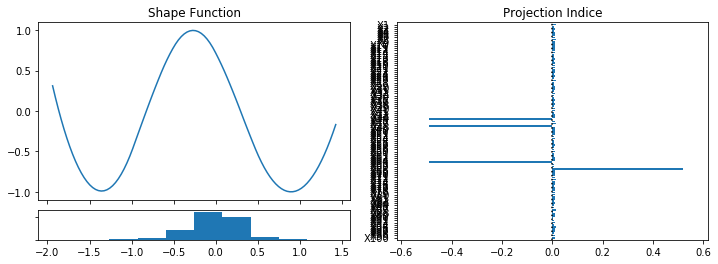

CPU times: user 23min 28s, sys: 53min 39s, total: 1h 17min 8s
Wall time: 1min 13s


In [9]:
%%time 

clf = SimRegressor(method="first_order", degree=2, knot_num=20, reg_gamma=1.0,  inner_update_method='Adam',
                 inner_update_lambda=0,
                 max_inner_iter=10, 
                 max_beta_iter=20,
                 learning_rate=0.1,
                 tol=1e-4, 
                 random_state=0)
clf.fit(x, y)
clf.visualize()